In [15]:
import torch
import pyro
import numpy as np
from hysteresis.meshing import exponential_mesh
from hysteresis.base import TorchHysteresis
from hysteresis.bayesian import LinearBayesianHysteresis, positional_covariance, low_hysteresis_prior
from hysteresis.training import train_bayes, train_torch, map_bayes
from hysteresis.visualization import plot_hysteresis_density
import matplotlib.pyplot as plt

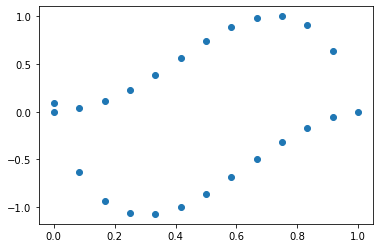

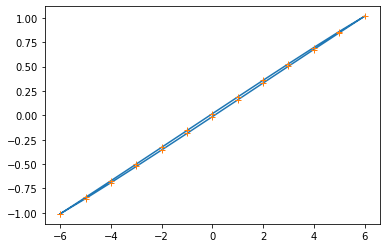

In [16]:
fname = '../facet_ii_data/quadrupoles/quad_m1-34.ru1'
data = []
with open(fname,'r') as f:
    f.readline()
    for line in f:
        temp = line.rstrip().split(' ')
        d = []
        for ele in temp:
            if ele != '':
                d += [ele]
        data += [d]
data = np.asfarray(data)
data[:, 1] = data[:, 1]
data[:, 3] = data[:, 3] * np.where(data[:,7] < 0, -1, 1)

# get real h, m
h = torch.tensor(data[:,1]).double()
m = torch.tensor(data[:,3]).double()

A = torch.min(h)
B = torch.max(h)
C = torch.min(m)
D = torch.max(m)

hn = (h - A) / (B - A)
mn = (m - C) / (D - C)
mt = mn - hn

E = torch.max(mt)
mf = mt / E

plt.plot(hn, mf, 'o')

plt.figure()
h_true = hn * (B-A) + A
m_true = (mf*E + hn) * (D-C) + C
plt.plot(h, m)
plt.plot(h_true, m_true, '+')


In [17]:
# Do MAP estimate w/o correlations
H_wo = LinearSubtractionHysteresis(hn, mesh_scale=0.5)
B_wo = LinearBayesianHysteresis(H_wo)
guide_wo, loss = map_bayes(hn, mf, B_wo, 10000)

calculated 25 states
[iteration 0001] loss: 398470.0322
[iteration 0101] loss: 333541.8438
[iteration 0201] loss: 272405.2423
[iteration 0301] loss: 215789.2586
[iteration 0401] loss: 164433.7789
[iteration 0501] loss: 119077.9928
[iteration 0601] loss: 80445.9634
[iteration 0701] loss: 49219.1384
[iteration 0801] loss: 25728.9948
[iteration 0901] loss: 10235.6373
[iteration 1001] loss: 3245.0142
[iteration 1101] loss: 2087.8331
[iteration 1201] loss: 1501.7766
[iteration 1301] loss: 1186.2084
[iteration 1401] loss: 1027.7414
[iteration 1501] loss: 943.8658
[iteration 1601] loss: 884.6794
[iteration 1701] loss: 836.3083
[iteration 1801] loss: 795.5532
[iteration 1901] loss: 760.7877
[iteration 2001] loss: 731.2196
[iteration 2101] loss: 705.7824
[iteration 2201] loss: 683.6383
[iteration 2301] loss: 664.3259
[iteration 2401] loss: 647.3484
[iteration 2501] loss: 632.3217
[iteration 2601] loss: 618.9377
[iteration 2701] loss: 606.9104
[iteration 2801] loss: 596.0108
[iteration 2901] los

calculated 24 states


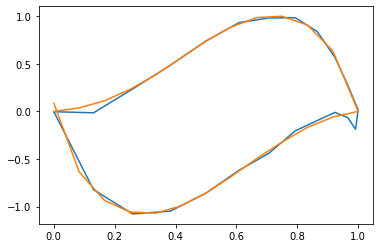

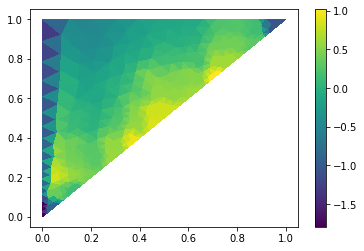

In [18]:
# make predictions
from hysteresis.bayesian_utils import predict
from hysteresis.visualization import plot_hysteresis_density

t = torch.linspace(0, np.pi, 25)
h_test = torch.sin(t)
pred_summary, samples = predict(h_test, B_wo, guide_wo)
mean = pred_summary['obs']['mean']

plt.plot(h_test, mean)
plt.plot(hn, mf)

dens = pred_summary['density']['mean'].detach().flatten()
fig,ax = plot_hysteresis_density(H_wo, dens)
